### Graph Neural Nets

![zkc](zkc.png)

Zachary's karate club (ZKC) is a social network of a university karate club, described in the paper "An Information Flow Model for Conflict and Fission in Small Groups" by Wayne W. Zachary. 

The social network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. 

During the study, a conflict arose between the officer/ administrator ("John A") and the instructor "Mr. Hi", which led to the split of the club into two. 

Part of the members formed a new club around Mr. Hi; and the remaining members went with the officer.

Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split. You could read more about it here https://en.wikipedia.org/wiki/Zachary%27s_karate_club, here https://www.jstor.org/stable/3629752, and here https://commons.wikimedia.org/wiki/File:Social_Network_Model_of_Relationships_in_the_Karate_Club.png

#### Import Dependencies

In [1360]:
import numpy as np
import networkx as ntwx
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML as web
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

%matplotlib inline

In [1361]:
def set_seed(seed=100):
    """sets seed"""
    np.random.seed(seed)

#### Processing Helper Functions

In [1362]:
def get_graph_metadata(graph, key=None):
    """Return metadata obout a graph i.e. number_of_nodes, number_of_edges and node attributes"""
    if key is None:
        return graph.number_of_nodes(), graph.number_of_edges()
    return graph.number_of_nodes(), graph.number_of_edges(), ntwx.get_node_attributes(graph, key)

def get_xavier_init(input_dim, output_dim):
    """returns xaviers in initializer"""
    std_dev = np.sqrt(5.0 / (input_dim + output_dim))
    return np.random.uniform(-std_dev, std_dev, size=(input_dim, output_dim))

def get_cross_entropy(pred, labels):
    """computes crossentropy between the predictions and the labels"""
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]


def normalized_difference_norm(dW, dW_approx):
    """compares the deirivarive of the weight with its apprimation"""
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))

def get_colors_labels_and_classes(graph, num_nodes):
    """We applied greedy modurality maximization from the original
    paper https://arxiv.org/pdf/1609.02907.pdf to come up with cluster
    labels for each of the members of the club. We will train our GNN
    to predict these cluster labels."""
    clusters = greedy_modularity_communities(graph)
    unsure_cluster = clusters[-1]
    clusters = clusters[:2]
    clusters[1] = clusters[1].union(unsure_cluster)
    color_lists = np.zeros(num_nodes)
    for i, cluster in enumerate(clusters):
        color_lists[list(cluster)] = i
    classes = np.unique(color_lists).shape[0]
    return color_lists, np.eye(classes)[color_lists.astype(int)], classes

def get_affiliation(club_labels):
    """return the affiation of the karate club members"""
    Mr_Hi, Officer = [], []
    for key, value in club_labels.items():
        if value == 'Mr. Hi':
            Mr_Hi.append(key)
        else:
            Officer.append(key)
    return Mr_Hi, Officer


def fill_diagonal(source_array, diagonal):
    """helps fill element of the source array into a diagonal matrix"""
    copy = source_array.copy()
    np.fill_diagonal(copy, diagonal)
    return copy
                                          

The original paper on greedy modularity communities maximization could be found here https://journals.aps.org/pre/pdf/10.1103/PhysRevE.70.066111?casa_token=Fqnjw_t-J64AAAAA%3ADmyzj146CDE-UeW_1I6Ifvu40GmCC_goDC4i6lvkYIa9GENKcktHxOgHO5et7Z7xJ3NU1q2Ngt2J6Zs

#### Visualization Helper Function

In [1363]:
def show_graph(graph,
               label_values_of_nodes,
               label_colors_of_nodes,
               colors_of_edges='black',
               display_window_size=15,
               positions_of_nodes=None,
               cmap='jet'):
    """helps visualize the graph"""
    fig, ax = plt.subplots(figsize=(display_window_size, display_window_size))
    if positions_of_nodes is None:
        # https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
        positions_of_nodes = ntwx.spring_layout(graph,
                                                k=5/np.sqrt(graph.number_of_nodes()))
        # https://networkx.org/documentation/stable/reference/drawing.html
    ntwx.draw(
        graph,
        positions_of_nodes,
        with_labels=label_values_of_nodes, 
        labels=label_values_of_nodes, 
        node_color=label_colors_of_nodes, 
        ax=ax,
    cmap=cmap,
    edge_color=colors_of_edges)
    
    
def plot_training_curves(train_losses, test_losses, grid=False):
    """shows training curves"""
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax1.plot(np.log10(train_losses), label='train')
    ax1.plot(np.log10(test_losses), label='test')
    ax1.legend()
    if grid:
        ax1.grid()
    
    ax2 = fig.add_subplot(122)
    ax2.plot(accs, label='acc')
    ax2.set(ylim=[0,1])
    ax2.legend()
    
    if grid:
        ax2.grid()

#### Gradient Update Helper Function

In [1364]:

def compute_gradients(param_name, layer, inputs_data, gt_labels, eps=1e-4, weight_decay=0):
    """Compute the gradient with respect to a a given parameter in a given layer"""
    gradients_utils = {}
    batch_size = gt_labels.shape[0]
    replica = getattr(layer, param_name).copy()
    replica_flattened = np.asarray(replica).flatten()
    gradients_utils['gradient_values'] = np.zeros(replica_flattened.shape)
    n_parms = replica_flattened.shape[0]
    for ind, param in enumerate(replica_flattened):
        # lower bound cost
        replica_flattened[ind] = param - eps
        temp = replica_flattened.reshape(replica.shape)
        gradients_utils['lower_bound_pred'] = layer.forward_pass(*inputs_data, **{param_name: temp})
        decay = weight_decay/ 2 * np.sum(replica_flattened ** 2) / batch_size
        lower_cost = np.mean(get_cross_entropy(gradients_utils['lower_bound_pred'],
                                               gt_labels)) + decay
        # upper bound cost
        replica_flattened[ind] = param + eps
        temp = replica_flattened.reshape(replica.shape)
        gradients_utils['upper_bound_pred'] = layer.forward_pass(*inputs_data, **{param_name: temp})
        decay = weight_decay/ 2 * np.sum(replica_flattened**2) / batch_size
        
        upper_cost = np.mean(get_cross_entropy(gradients_utils['upper_bound_pred'],
                                               gt_labels)) + decay
        gradients_utils['gradient_values'][ind] = ((upper_cost - lower_cost) / (2 * eps))
        replica_flattened[ind] = param
    return gradients_utils['gradient_values'].reshape(replica.shape)

#### Grad Descent Optimizer Helper Function

In [1365]:
class Grad_Descent_Optimizer():
    """Performs Gradient Descent"""
    def __init__(self, learning_rate, weight_decay):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self._y_pred = None
        self._y_true = None
        self._output = None
        self.batch_size = None
        self.nodes_to_be_trained = None
        
    def __call__(self, y_pred, y_true, nodes_to_be_used_for_training=None):
        self.y_pred = y_pred
        self.y_true = y_true
        self.batch_size = y_pred.shape[0]
        
        if nodes_to_be_used_for_training is None:
            self.nodes_to_be_used_for_training = np.arange(self.batch_size)
        else:
            self.nodes_to_be_used_for_training = nodes_to_be_used_for_training
        
    @property
    def out(self, ):
        return self._output
    
    @out.setter
    def out(self, y):
        self._output = y

#### Set seed

In [1366]:
set_seed()

#### Implementation Check Helper Function

In [1367]:
def implementation_check(dW, dW_approx, db, db_approx):
    """This function helps check how correct in your impplementation a layer"""
    try:
        assert normalized_difference_norm(dW, dW_approx) < 1e-7
        assert normalized_difference_norm(db, db_approx) < 1e-7
        print('congrats, your implementation passes the test !!!')
    except:
        print('Not quite there :( yet; your implementation did not pass the test')

#### Training Helper Function

In [1368]:
def train_test_split(test_nodes, labels):
    return np.array([i for i in range(labels.shape[0]) if i not in test_nodes])

def threshold(arr, threshold_value=0.5):
    """This function treshold the output of a softmax to either be 0 or 1"""
    arr[arr>=threshold_value]=1
    arr[arr<threshold_value]=0
    return arr

#### Node Classification Helper Function

In [1369]:
class Softmax_Layer():
    """applies a weight multiplication and returns the forward and backward passes softmax. Some values are cached 
    so we could use them to compute the gredients.
    Returns: (batch_size, output_dim)"""
    def __init__(self, input_dim, output_dim, name=''):
        self.name = name
        self.cache = {}
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.bias = np.zeros((self.output_dim, 1))
        self.W = get_xavier_init(self.output_dim, self.input_dim)
        
    def __repr__(self):
        dims = (self.input_dim, self.output_dim)
        if self.name:
            return f"Softmax_Layer: W{'_' + self.name}{dims}"
        else:
            return f"Softmax_Layer: W{'_'+ ''}{dims}"
        
    def get_softmax(self, x):
        x = x - np.max(x, axis=0, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)
        
    def forward_pass(self, X, W=None, bias=None):
        """Returns the softmax of the input X after appliying the weight and biases."""
        self.cache['X'] = X.T
        if W is None:
            W = self.W
        if bias is None:
            bias = self.bias

        return self.get_softmax(np.asarray(W @ self.cache['X']) + bias).T # (batch_size, output_dim)
    
    def backward_pass(self, optimizer, need_update=True):
        """mask nodes nodes not revelant for training, and updates optimizer parameters"""
        training_mask = np.zeros(optimizer.y_pred.shape[0])
        training_mask[optimizer.nodes_to_be_trained] = 1
        training_mask = training_mask.reshape((-1, 1))
        
        dLoss = np.asarray((optimizer.y_pred - optimizer.y_true)) 
        dLoss = np.multiply(dLoss, training_mask)
        
        self.grad = dLoss @ self.W # (batch_size, input_dim)
        optimizer.output = self.grad
        
        dW = (dLoss.T @ self.cache['X'].T) / optimizer.batch_size # (output_dim, input_dim)
        dbias = np.sum(dLoss.T, axis=1, keepdims=True) / optimizer.batch_size # (output_dim, 1)
                
        dW_weight_decay = self.W * optimizer.weight_decay / optimizer.batch_size
        
        if need_update:   
            self.W = self.W - (dW + dW_weight_decay) * optimizer.learning_rate
            self.bias = self.bias - dbias.reshape(self.bias.shape) * optimizer.learning_rate
        
        return dW + dW_weight_decay, dbias.reshape(self.bias.shape)

### ZKC

We will train a GNN to cluster people in the karate club in such that people who are more likely to associate with either the officer or Mr. Hi will be close together, while the distance beween the 2 classes will be far.

In the original paper titled "Semi-Supervised Classification with
Graph Convolutional Networks" that can be found here https://arxiv.org/pdf/1609.02907.pdf, the authors framed this as a node-level classification problem on a graph. We will pretend that we only know the affiliation labels for some of the nodes (which we'll call our training set) and we'll predict the affiliation labels for the rest of the nodes (our test set).

We will build a multi-layer Graph Convolutional Network (GCN) with the following layer-wise propagation rule:

$$H^{(l+1)} = σ(D^{-1/2}\tilde{A} D^{-1/2}H^{(l)}W^{(l)})
            = σ(\tilde{A}^{SymNorm}H^{(l)}W^{(l)})$$

where $\tilde{A}$ is the adjacency matrix that we discussed in Homework 4, except that now we add the identity to include self loops at every node for numerical stability. $D$ is the degree matrix as defined in the past, $H^{(l)}$ is the activation matrix of the $l$-th layer, and $W$ is the weight matrix to be learned. $\sigma$ is an activation function, in this case tanh.

We used the python module networkx to import the dataset and provided some helper functions to help understand the data as shown below.

In [1370]:
graph = ntwx.karate_club_graph()
num_nodes, num_edges, club_labels = get_graph_metadata(graph, 'club')
colors, labels, num_classes = get_colors_labels_and_classes(graph, num_nodes)
Mr_Hi_people, Officer_people = get_affiliation(club_labels)

### Data Inspection

In [1371]:
print(f'ZKC dataset graph has {num_nodes} nodes and {num_edges} edges')

ZKC dataset graph has 34 nodes and 78 edges


In [1372]:
print(f'The affiation of each of the 34 members between the officer and Mr. Hi is given below:\n {club_labels}')

The affiation of each of the 34 members between the officer and Mr. Hi is given below:
 {0: 'Mr. Hi', 1: 'Mr. Hi', 2: 'Mr. Hi', 3: 'Mr. Hi', 4: 'Mr. Hi', 5: 'Mr. Hi', 6: 'Mr. Hi', 7: 'Mr. Hi', 8: 'Mr. Hi', 9: 'Officer', 10: 'Mr. Hi', 11: 'Mr. Hi', 12: 'Mr. Hi', 13: 'Mr. Hi', 14: 'Officer', 15: 'Officer', 16: 'Mr. Hi', 17: 'Mr. Hi', 18: 'Officer', 19: 'Mr. Hi', 20: 'Officer', 21: 'Mr. Hi', 22: 'Officer', 23: 'Officer', 24: 'Officer', 25: 'Officer', 26: 'Officer', 27: 'Officer', 28: 'Officer', 29: 'Officer', 30: 'Officer', 31: 'Officer', 32: 'Officer', 33: 'Officer'}


In [1373]:
print(f'nodes/people loyal to Mr. Hi are:\n {Mr_Hi_people}')

nodes/people loyal to Mr. Hi are:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]


In [1374]:
print(f'nodes/people loyal to the officer are:\n {Officer_people}')

nodes/people loyal to the officer are:
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [1375]:
assert len(Officer_people) + len(Mr_Hi_people) == num_nodes

Note that the nodes represent the people and the edges represent the social interaction between the people outside on the club. Also the colors assigned to the nodes as shown below are indepedent of the class since no model has been trained to properly do that.

##### Show Graph with Labels

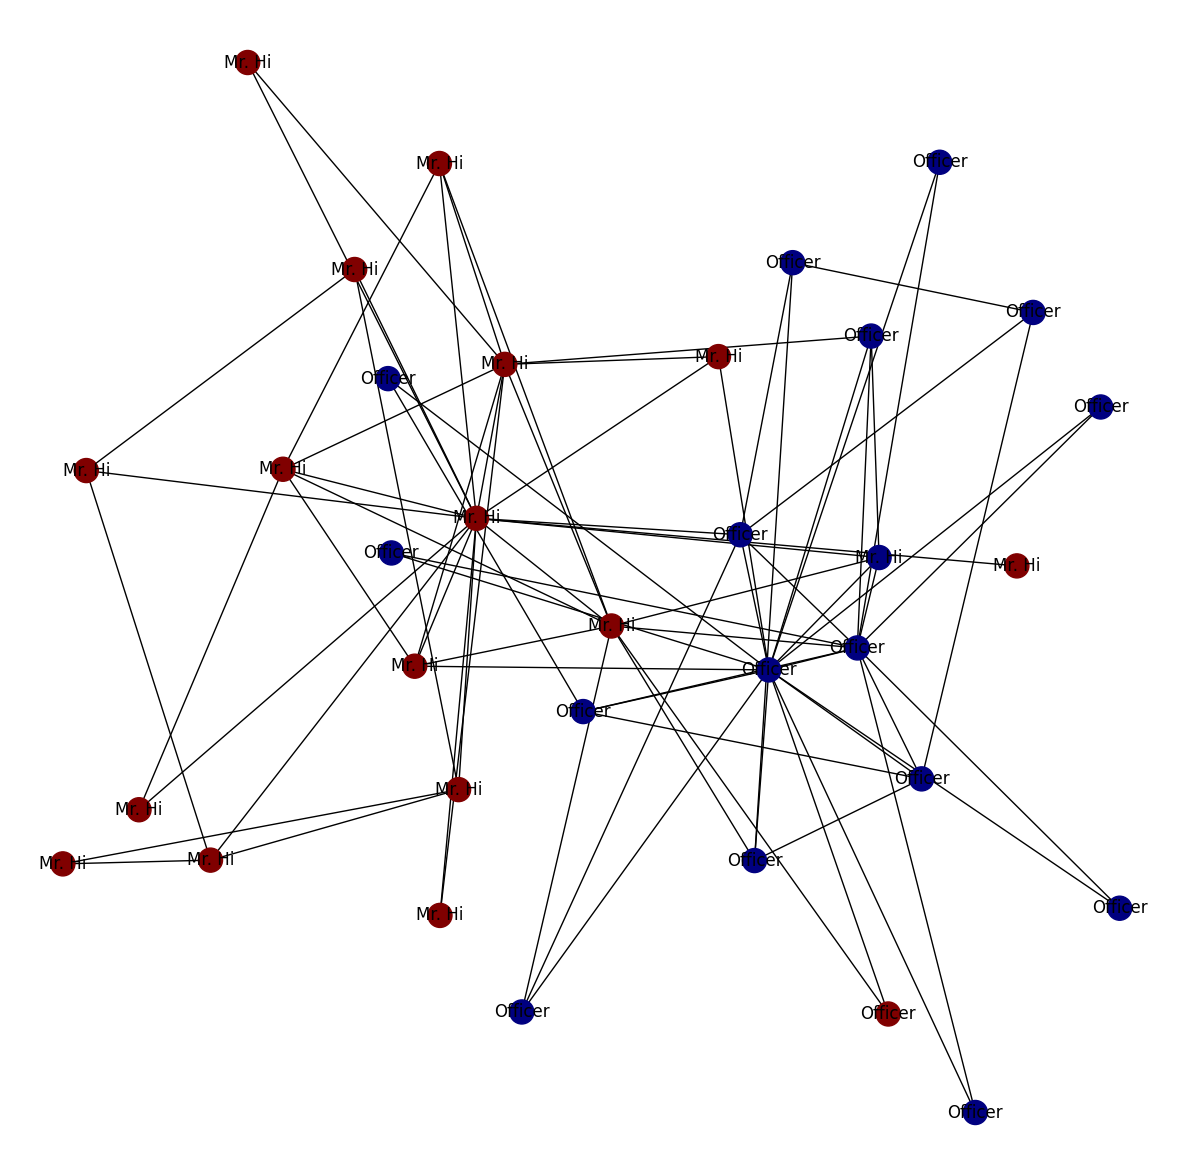

In [1376]:
show_graph(graph=graph,
           label_values_of_nodes=club_labels,
           label_colors_of_nodes=colors,
           colors_of_edges='black',
           positions_of_nodes=None)

##### Show Graph without Labels

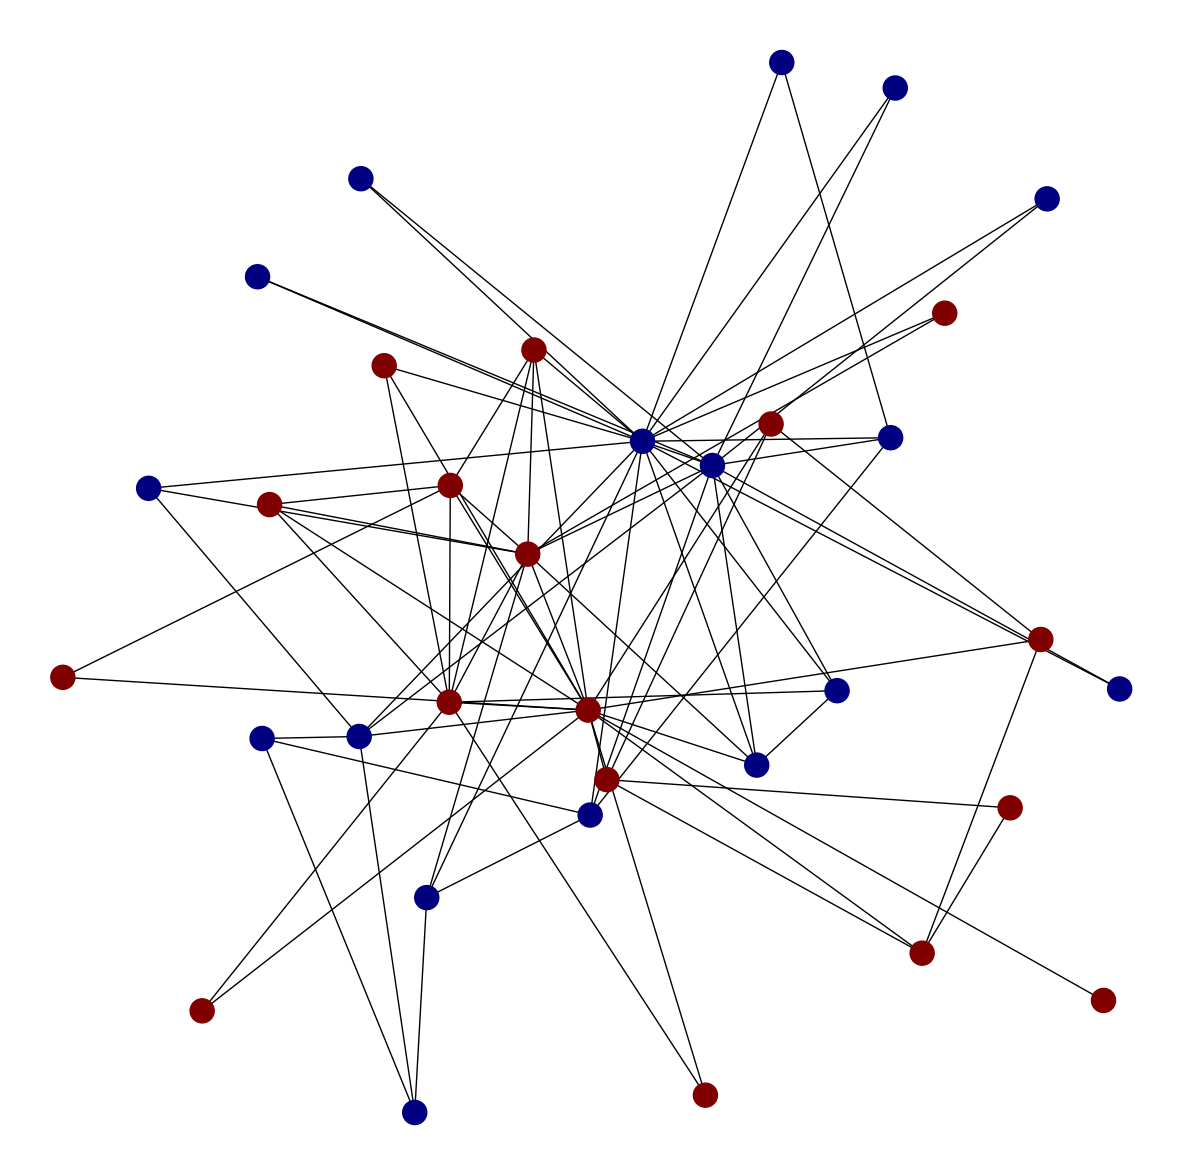

In [1377]:
show_graph(graph=graph,
           label_values_of_nodes=None,
           label_colors_of_nodes=colors,
           colors_of_edges='black',
           positions_of_nodes=None,)

Note that node labels are obtained using the greedy modurality maximization algorithm descibted in the paper linked above.

Our goal in this problem is therefore to write a simple Graph Neural Network using python to perform node classification. We will also use the node embedding to move nodes with similar classes close to each other. We have provided here the adjacency matrix of the graph.

In [1378]:
A = ntwx.to_numpy_matrix(graph)
A

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

Note that we adjacency matrix does not include the node itself. We want our network to be aware of information about the nodes themselves instead of only the neighborhood, so we add self loops our adjacency matrix. The paper called this $\tilde A$.

#### Q. 1. Compute: $$\tilde{A}=A_{self-loop}= A + I$$
Where I is the identity matrix which allows us to include self loops of each nodes.

In [1379]:
# TODO
A_tild = A + np.identity(len(A)) 
print(len(A_tild))

34


#### Q.2. Write a function that takes in $\tilde A$ as argument and returns the $\tilde A^{SymNorm}$ adjacency matrix. You may find the provided function `fill_diagonal` useful, as well as the inverse function `np.linalg.inv` and the matrix square root function `np.linalg.sqrtm`.

In [1380]:
def get_adjacency_matrix(A_tild):
    # TODO
    diagonals = np.sum(A_tild, axis=0)
    source_array = np.zeros_like(A_tild)
    D = fill_diagonal(source_array, diagonals)
    D_sqrt = np.sqrt(np.linalg.inv(D))
    A_sym = D_sqrt @ A_tild @ D_sqrt
    return A_sym

In [1381]:
A_hat = get_adjacency_matrix(A_tild)
A_hat

matrix([[0.05882353, 0.0766965 , 0.07312724, ..., 0.09166985, 0.        ,
         0.        ],
        [0.0766965 , 0.1       , 0.09534626, ..., 0.        , 0.        ,
         0.        ],
        [0.07312724, 0.09534626, 0.09090909, ..., 0.        , 0.0836242 ,
         0.        ],
        ...,
        [0.09166985, 0.        , 0.        , ..., 0.14285714, 0.10482848,
         0.08908708],
        [0.        , 0.        , 0.0836242 , ..., 0.10482848, 0.07692308,
         0.06537205],
        [0.        , 0.        , 0.        , ..., 0.08908708, 0.06537205,
         0.05555556]])

The other input to our GNN is the graph node matrix $X$ which contains node features. For simplicity, we set $X$ to be the identity matrix because we don't have any node features in this example. In a sense, this will map each node in the graph to a column of learnable parameters in the first layer, resulting in a fully learnable node embedings. In the question below, set the matrix $X$ to be the identity.

##### Q.3. Generate the feature input matrix $X$

In [1382]:
# TODO
X = np.identity(len(A_hat)) # don't know the dim
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Single GNN Layer Implementation

We will first implement a single layer GNN. Using the equation provided in the paper that is mentioned above, implement a forward and backward pass for a simple GNN layer. 

Note that for $l$=0, $H$ is the input $X$ and $\tilde A H$ does the message passing as we have seen in the previous homework and discussion, which is in turn multiplied by a weight matrix $W$. A non linearity is therefore applied afterward.


In the backward pass, we will apply L2 regularization to the weight matrix $W$. The regularization term is defined as: $\lambda \sum_{i,j} W_{i,j}^2$ which has gradient: $\lambda 2W$. We will combine $\lambda 2$ in the weight decay parameter optimizer.weight_decay.

#### Q.4. Complete the #TODO to implement a forward pass that does just that in the class below.

In [1383]:
class GNN_Layer():
    """process a single GNN layer"""
    def __init__(self, input_dim, output_dim, name=''):
        self.name = name
        self.cache = {}
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = get_xavier_init(self.output_dim, self.input_dim)
        self.activation = np.tanh
        
    def __repr__(self):
        dims = (self.input_dim, self.output_dim)
        if self.name:
            return f"GNN_Layer: W{'_' + self.name}{dims}"
        else:
            return f"GNN_Layer: W{'_'+ ''}{dims}"
        
    def forward_pass(self, A, X, W=None):
        """A here is the symmetricaly normalized adjacency matrix
        and X is the input to the layer. We cached some values 
        to use in the backward pass."""
        
        self.cache['A'] = A # (batch_size, batch_size)
        # TODO 
        self.cache['X'] = X # (input_node_feature_dim, batch_size)
        
        if W is None:
            W = self.W
        # print(self.W)
        H = A @ X @ W.T # (hidden_dim, batch_size)
        H = self.activation(H)# [apply activation] (hidden_dim, batch_size)
        self.cache['H'] = H # (hidden_dim, batch_size)
        return H # (batch_size, hidden_dim)
    
    def backward_pass(self, optimizer, need_update=True):
        dtanh = np.ones_like(self.cache['H']) - np.power(self.cache['H'], 2) # (batch_size, output_dim) 34,2
        # optimizer.output contains the gradient from the next layer. It is multiplied by the batch size,
        # so you'll need to divide by optimizer.batch_size to get the average gradient.
        d = np.multiply(optimizer.output, dtanh) # (batch_size, output_dim) 34, 2
        # assert (len(d), len(d[0])) == (len(self.cache['A'], self.input_dim))
        # print(d)
        self.grad = self.cache['A'] @ d @ self.W/optimizer.batch_size  # (batch_size, input_dim)
        
        optimizer.output = self.grad
        
        # print(self.cache['X'])
        dW = d.T @ self.cache['A'] @ self.cache['X'] # (output_dim, input_node_feature_dim)
        dW_weight_decay = self.W * optimizer.weight_decay / optimizer.batch_size
        dW = dW + dW_weight_decay
        if need_update: # Use the gradient descent update rule on W. Remember to include weight decay.
            self.W = self.W - optimizer.learning_rate * dW
        
        return dW # (output_dim, input_node_feature_dim)

#### We now test the your implementation

lets's instantiate the GNN_Layer Class and the Softmax_Layer provided in the helper functions to test the gradients.

In [1384]:
gnn_layer = GNN_Layer(input_dim=num_nodes,
                output_dim=2,
                name='gnn_layer_1')

sm_layer = Softmax_Layer(input_dim=2,
                   output_dim=num_classes,
                   name='softmax_layer')

optim = Grad_Descent_Optimizer(learning_rate=0,
                               weight_decay=1.)

####  Q. 6. lets compute the forward passes, uncomment and complete

In [1385]:
# TODO
gnn_layer_output = gnn_layer.forward_pass(A=A_hat,
                                          X=X)
# gnn_layer_output
y_pred=sm_layer.forward_pass(X=gnn_layer_output)
y_pred
optim(y_pred=sm_layer.forward_pass(X=gnn_layer_output), y_true=labels)

lets verify that the layers are properly implemented by looking at the gradients. Note that need update is used only when we are updating the parameters during training. We do not need to do so here since we are just testing our layers.

In [1386]:
dW_approx = compute_gradients(param_name="W",
                              layer=sm_layer,
                              inputs_data=(gnn_layer_output,),          
                              gt_labels=labels,
                              eps=1e-4,
                              weight_decay=optim.weight_decay)

db_approx = compute_gradients(param_name="bias",
                              layer=sm_layer,
                              inputs_data=(gnn_layer_output,),
                              gt_labels=labels,
                              eps=1e-4,
                              weight_decay=optim.weight_decay)

In [1387]:
dW, db = sm_layer.backward_pass(optim, need_update=False)

We then get the gradients of Softmax layer.

In [1388]:
dW, db = sm_layer.backward_pass(optim, need_update=False)

#### We now assert that the true and approximate gradients are very close to each other. If not, something went wrong in our implementation.

In [1389]:
implementation_check(dW, dW_approx, db, db_approx)

congrats, your implementation passes the test !!!


#### Q. 5. Now,  use the GNN and Softmax layers implemented above to set up our GNN Network. 

In [1390]:
class GNN():
    """This class leverages the GNN layer implemanted above by cascading them into a layer."""
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dim,
                 num_layers,):
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.layers = []
        first_gnn_layer = GNN_Layer(input_dim=input_dim,
                                  output_dim=hidden_dim[0],
                                  name='layer_0')
        
        self.layers.append(first_gnn_layer)
        
        for layer in range(num_layers - 1):
            gnn_temp = GNN_Layer(input_dim=hidden_dim[layer],
                                 output_dim=hidden_dim[layer + 1],
                                 name=f'layer_{layer}')
            self.layers.append(gnn_temp)
            
 
        last_gnn_layer = Softmax_Layer(input_dim=hidden_dim[-1],
                               output_dim=output_dim,
                               name='sm_layer')
        self.layers.append(last_gnn_layer)
        
    def __repr__(self):
        return '\n'.join([str(layer) for layer in self.layers])
    
    def embedding(self, A, X):
        H = X
        for layer in self.layers[:-1]:
            H = layer.forward_pass(A, H)
            pass
        return H
    
    def forward_pass(self, A, X):
        H = X
        out = self.layers[-1].forward_pass(H)
        pass
        return out

#### Q.6. uncomment and complete

In [1391]:
gnn_model = GNN(
    input_dim=num_nodes, 
    output_dim=num_classes, 
    num_layers=2,
    hidden_dim=[16, 2], 
)
gnn_model

GNN_Layer: W_layer_0(34, 16)
GNN_Layer: W_layer_0(16, 2)
Softmax_Layer: W_sm_layer(2, 2)

#### Train/ Test split

We chose nodes 0, 1, 8, 3, 8, 15, 16, 20, 25, 28, and 30 t to be our test nodes and used all the remaining for training.

In [1392]:
test_nodes = np.array([0, 1, 8, 3, 8, 15, 16, 20, 25, 28, 30])
train_nodes = train_test_split(test_nodes, labels)

In [1393]:
print(f'The nodes that will be used for training are:\n {train_nodes}')

The nodes that will be used for training are:
 [ 2  4  5  6  7  9 10 11 12 13 14 17 18 19 21 22 23 24 26 27 29 31 32 33]


In [1394]:
print(f'The nodes that will be used for test/val are:\n {test_nodes}')

The nodes that will be used for test/val are:
 [ 0  1  8  3  8 15 16 20 25 28 30]


We now instantiate our optimizer with a learning rate and weight decay for training.

In [1395]:
training_optim = Grad_Descent_Optimizer(learning_rate=2e-2, weight_decay=2.5e-2)

#### Q.7 Complete the training loop function below.  Note that the train loss and test loss are computed over a given set of nodes that is defined by our training and testing set.

In [1396]:
def train(model,
          A_hat,
          X,
          y_true,
          nodes_to_be_used_for_training,
          nodes_to_be_used_for_testing,
          threshold_value=.5,
          ealy_stopping_steps=60,
          num_epochs=20000):
    """trains our gnn model"""
    
    accs = []
    training_losses = []
    testing_losses = []
    embeddings = []
    y_preds = []

    minimum_loss = 1e7
    ealy_stopping_counter = 0
    
    for epoch in range(num_epochs):
        # TODO
        # print(len(A_hat))
        # print(X)
        H = model.embedding(A_hat, X)
        y_pred = model.forward_pass(A_hat, H)
        training_optim(y_pred, y_true, nodes_to_be_used_for_training)

        for layer in reversed(model.layers):
            layer.backward_pass(training_optim, need_update=True)

        embeddings.append(model.embedding(A_hat, X))
        y_preds.append(y_pred)
        acc_temp = (np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))[
            [i for i in range(y_true.shape[0]) if i not in nodes_to_be_used_for_training]
        ]
        accs.append(np.mean(acc_temp))
        # l2 = np.sum(np.power(y_pred - y_true, 2), axis = 1)
        # print(l2)
        loss_temp = get_cross_entropy(y_pred, y_true)
        train_loss_temp = np.mean(loss_temp[nodes_to_be_used_for_training])
        test_loss_temp = np.mean(loss_temp[nodes_to_be_used_for_testing])

        training_losses.append(train_loss_temp)
        testing_losses.append(test_loss_temp)

        if test_loss_temp < minimum_loss:
            minimum_loss = test_loss_temp
            ealy_stopping_counter = 0
        else:
            ealy_stopping_counter += 1

        if ealy_stopping_counter > ealy_stopping_steps:
            print("Training Stopped due to Early stopping!")
            break

        if epoch % 100 == 0:
            print(f"epoch #: {epoch+1} \t| train Loss: {train_loss_temp:.3f} \t| test Loss: {test_loss_temp:.3f}")

    training_losses = np.array(training_losses)
    testing_losses = np.array(testing_losses)
    y_preds = threshold(np.array(y_preds), threshold_value)
    return training_losses, testing_losses, accs, embeddings, y_preds

In [1397]:
training_losses, testing_losses, accs, embeddings, preds = train(model=gnn_model,
                                  A_hat=A_hat,
                                  X=X,
                                  y_true=labels,
                                  nodes_to_be_used_for_training=train_nodes,
                                  nodes_to_be_used_for_testing=test_nodes,
                                  ealy_stopping_steps=50,
                                  num_epochs=20000)

epoch #: 1 	| train Loss: 0.691 	| test Loss: 0.690
epoch #: 101 	| train Loss: 0.666 	| test Loss: 0.664
epoch #: 201 	| train Loss: 0.551 	| test Loss: 0.551
epoch #: 301 	| train Loss: 0.305 	| test Loss: 0.315
epoch #: 401 	| train Loss: 0.163 	| test Loss: 0.185
epoch #: 501 	| train Loss: 0.101 	| test Loss: 0.129
epoch #: 601 	| train Loss: 0.068 	| test Loss: 0.097
epoch #: 701 	| train Loss: 0.049 	| test Loss: 0.075
epoch #: 801 	| train Loss: 0.038 	| test Loss: 0.060
epoch #: 901 	| train Loss: 0.030 	| test Loss: 0.049
epoch #: 1001 	| train Loss: 0.025 	| test Loss: 0.041
epoch #: 1101 	| train Loss: 0.021 	| test Loss: 0.035
epoch #: 1201 	| train Loss: 0.018 	| test Loss: 0.030
epoch #: 1301 	| train Loss: 0.016 	| test Loss: 0.026
epoch #: 1401 	| train Loss: 0.014 	| test Loss: 0.024
epoch #: 1501 	| train Loss: 0.013 	| test Loss: 0.021
epoch #: 1601 	| train Loss: 0.012 	| test Loss: 0.019
epoch #: 1701 	| train Loss: 0.011 	| test Loss: 0.018
epoch #: 1801 	| train

In [1398]:
print(f'For this toy example, the classification accuracy on the test set is {accs[-1]}')

For this toy example, the classification accuracy on the test set is 1.0


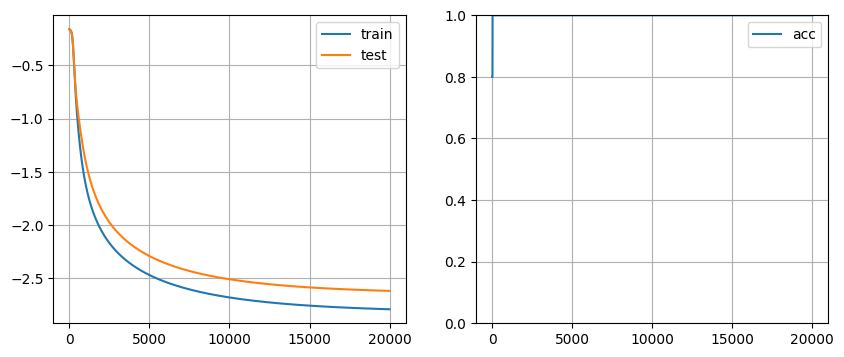

In [1399]:
plot_training_curves(training_losses, testing_losses, accs)

#### Results

Let's observe the affiliation of people in our test nodes.

In [1400]:
[club_labels[i] for i in test_nodes]

['Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Officer',
 'Mr. Hi',
 'Officer',
 'Officer',
 'Officer',
 'Officer']

Let's observe the position where our trainined model predict them to be at.

In [1401]:
embeddings[-1][test_nodes]

matrix([[-0.99874223, -0.99701729],
        [-0.9914372 , -0.98281763],
        [ 0.755191  ,  0.70402521],
        [-0.99395529, -0.98773063],
        [ 0.755191  ,  0.70402521],
        [ 0.97652206,  0.96057142],
        [-0.9683016 , -0.95036331],
        [ 0.97864815,  0.96357556],
        [ 0.99467299,  0.98829316],
        [ 0.78808234,  0.73381549],
        [ 0.8735478 ,  0.83374086]])

Let's observe the GT for values for the test nodes.

In [1402]:
labels[test_nodes]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Let's observe the predicted values for them.

In [1403]:
preds[-1][test_nodes]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Finally, lets observe all the data clustered.

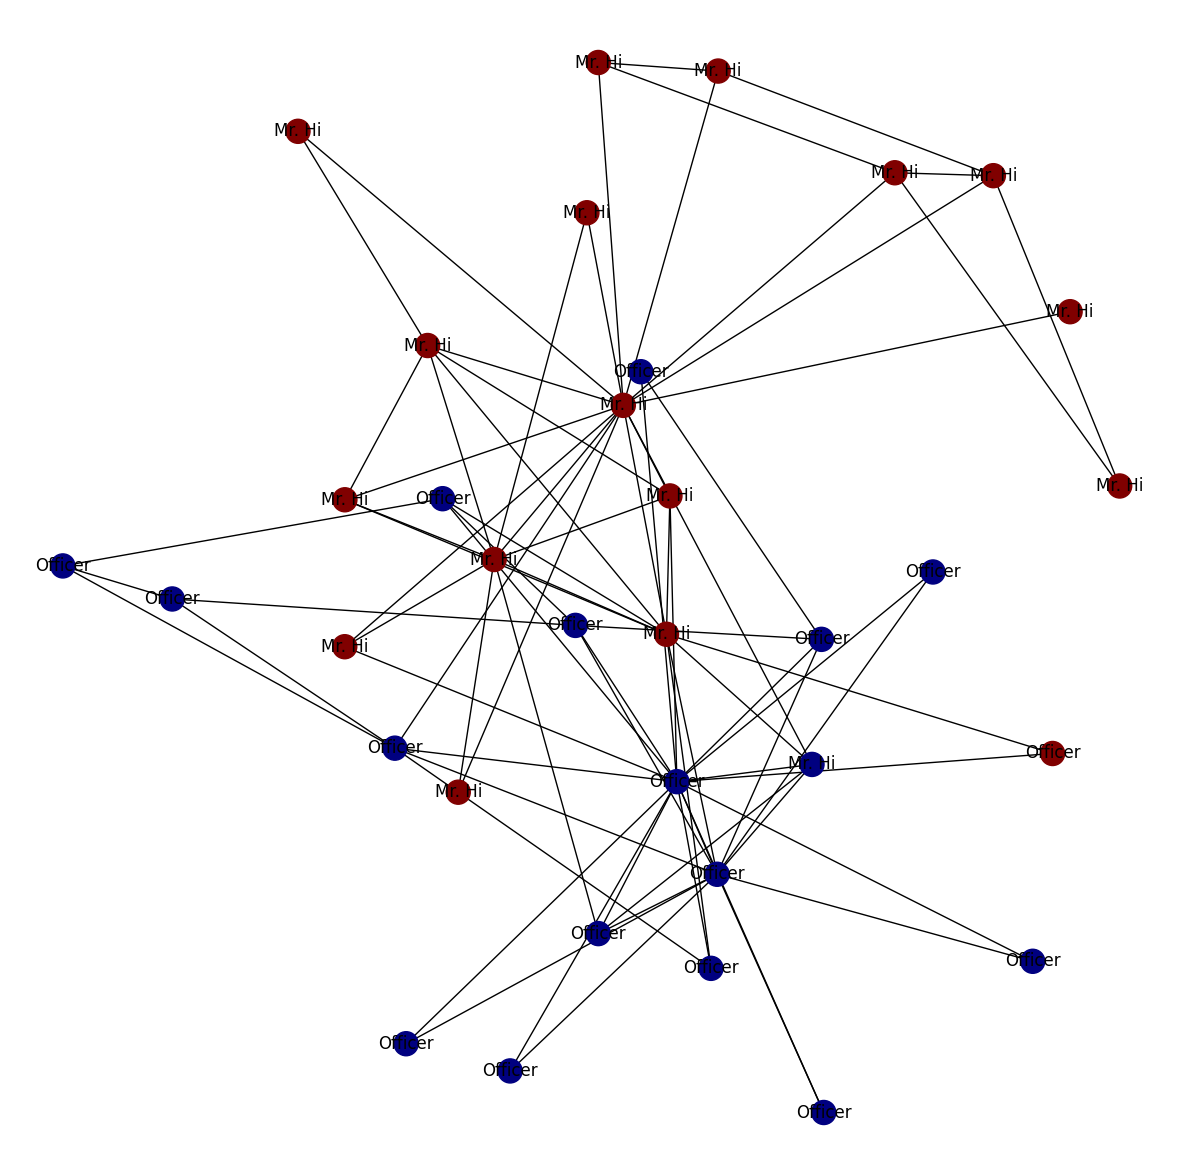

In [1404]:
show_graph(graph=graph,
           label_values_of_nodes=club_labels,
           label_colors_of_nodes=colors,
           colors_of_edges='black',
           positions_of_nodes = None,
        #    positions_of_nodes={i: embeddings[-1][i,:] \
        #                        for i in range(embeddings[-1].shape[0])},
          )

#### Q. 8. Explain why we obtain a 100% on accuracy on our test set, yet we see in the plot above that 2 samples seem to be misclassified.

1. Test nodes doesn't include all nodes. 
2. Wrongly classified nodes connect to nodes with both classes. That makes it difficult to classify them.